In [1]:
from astropy.io import fits
import astropy.convolution as astroconv
import time
from heeps.util.img_processing import resize_img, pad_img, crop_img
import imutils
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
maskM1 = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/mask_M1.fits')
spiders = fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/SpiderShadow.fits')
nimg = 10526                # size of the high-res pupil image
phot_spiders_L = 3.5        # pixels on the spiders (for 1 inside the pupil)
phot_spiders_N = 4.3
phot_envirnt_L = 4.3        # pixels outside the pupil (for 1 inside the pupil)
phot_envirnt_N = 5.1
pupil_img_size = 39.9988    # pupil image in m
diam_max_M1 = 39.146        # max diameter of M1 in m
FWHM_L = 0.0034             # Gaussian kernel FWHM
FWHM_N = 0.0076 
nphotons_max_pix = 100000   # number of photons on the brightest pixel
ngrid = 2048                # size of the detector
npix_M1_L = 1473            # size of M1 pupil at the detector
npix_M1_N = 1548 

In [3]:
def pupil_emission(phot_envirnt, phot_spiders):
    pup = maskM1*(1 + (1 - spiders)*(phot_spiders - 1)) + (1 - maskM1)*phot_envirnt
    imshow(pup, origin=True)
    return pup

def make_gaussian_kernel(fwhm, size_fwhm=0.5):
    npupil = round(fwhm/size_fwhm)
    npupil += 1 - npupil % 2 # must be odd
    x = np.arange(0, npupil, 1, float)
    y = x[:,np.newaxis]
    center = npupil // 2
    kernel = np.exp(-4*np.log(2) * ((x-center)**2 + (y-center)**2) / fwhm**2)
    imshow(kernel, origin=True)
    print('npupil=%s ;'%npupil, 'center=%s ;'%(center+1), 'fwhm=%s pixels'%round(fwhm, 2))
    return kernel

def convolve_pupil(pup, kernel):
    t0 = time.time()
    pup_conv = astroconv.convolve(pup, kernel, boundary='extend')
    imshow(pup_conv, origin=True)
    print('duration=%s s'%round(time.time() - t0))
    return pup_conv

def resize_to_detector(pup_start, start, end, padding=0, precision=1e-3, stop=1e6):
    t0 = time.time()
    print('start=%s, end=%s'%(round(start, 2), end))
    scale = end/start
    size = np.array([(x, x*scale) for x in np.arange(int(start), stop) \
        if x*scale % 1 < precision \
        and bool(x%2) is bool(round(x*scale)%2)]) # x and (x*scale) must have same parity
    assert np.any(size), "couldn't find a size: relax precision or increase stop value."
    n1, n2 = size[0]
    print('n1=%s, n2=%s'%(n1, n2))
    n1 = int(round(n1))
    n2 = int(round(n2))
    pup_end = resize_img(pad_img(resize_img(pup_start, n1), n2, padding), end)
    print('duration=%s s'%round(time.time() - t0))
    return pup_end, n1, n2

def make_detector_img(pup_img, npix_M1, phot_envirnt):
    # resize to detector
    start = npix_M1*pupil_img_size/diam_max_M1
    end = ngrid
    det_img, n1, n2 = resize_to_detector(pup_img, start, end, padding=phot_envirnt)
    # rescale to max photons per pixel (100k)
    det_img *= nphotons_max_pix/phot_envirnt
    # add photon noise
    det_img += np.random.normal(0, np.sqrt(det_img))
    imshow(det_img, origin=True)
    return det_img, n1, n2

def calc_chi2(phot_envirnt, nrot=5, drot=0.1):
    chi2s = []
    for i in range(nrot+1):
        t0 = time.time()
        pup_rot = imutils.rotate(pup, angle=i*drot)
        pup_rot[pup_rot==0] = phot_envirnt
        pup_rot = resize_img(pad_img(resize_img(pup_rot, n1), n2, phot_envirnt), ngrid)
        pup_rot *= nphotons_max_pix/phot_envirnt
        chi2 = np.sum((det_img-pup_rot)**2/pup_rot)/(ngrid - 1)**2
        print('chi2=%s, duration=%s s'%(round(chi2, 2), round(time.time() - t0)))
        chi2s.append(chi2)
    x = np.arange(nrot+1)*drot
    plot(x, chi2s, '-*')
    xlim(left=0)
    ylim(bottom=0)
    xlabel('clocking error(°)')
    ylabel('$\chi^2$')
    return chi2s

# L band

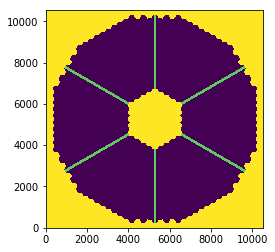

In [4]:
pup = pupil_emission(phot_envirnt_L, phot_spiders_L)
fits.writeto('pupil_emission_L.fits', pup, overwrite=True)

npupil=71 ; center=36 ; fwhm=35.03 pixels


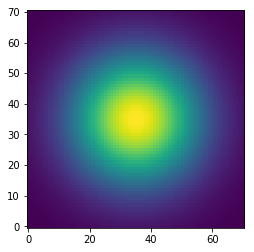

In [5]:
kernel = make_gaussian_kernel(FWHM_L*nimg*diam_max_M1/pupil_img_size)
fits.writeto('kernel_L.fits', kernel, overwrite=True)

duration=529 s


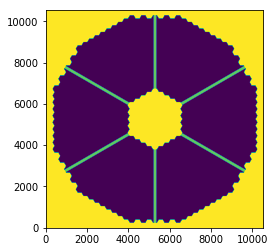

In [6]:
pup_img = convolve_pupil(pup, kernel)
fits.writeto('pup_img_L.fits', pup_img, overwrite=True)

start=1505.09, end=2048
n1=7036.0, n2=9574.000938425981
duration=8 s


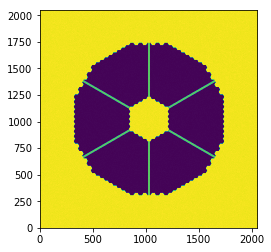

In [7]:
det_img, n1, n2 = make_detector_img(pup_img, npix_M1_L, phot_envirnt_L)
fits.writeto('det_img_L.fits', det_img, overwrite=True)

chi2=107.53, duration=8 s
chi2=139.64, duration=8 s
chi2=231.4, duration=8 s
chi2=370.07, duration=8 s
chi2=538.1, duration=8 s
chi2=723.89, duration=8 s


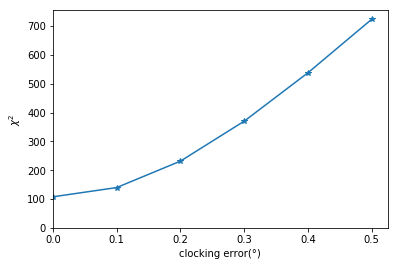

In [8]:
chi2s = calc_chi2(phot_envirnt_L, nrot=5, drot=0.1)
savefig('chi2_L.png', dpi=300, transparent=True)

# N band

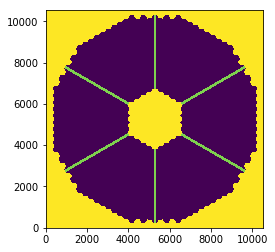

In [9]:
pup = pupil_emission(phot_envirnt_N, phot_spiders_N)
fits.writeto('pupil_emission_N.fits', pup, overwrite=True)

npupil=157 ; center=79 ; fwhm=78.29 pixels


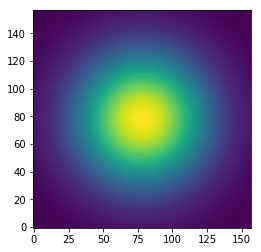

In [10]:
kernel = make_gaussian_kernel(FWHM_N*nimg*diam_max_M1/pupil_img_size)
fits.writeto('kernel_N.fits', kernel, overwrite=True)

duration=2574 s


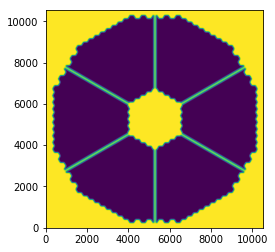

In [11]:
pup_img = convolve_pupil(pup, kernel)
fits.writeto('pup_img_N.fits', pup_img, overwrite=True)

start=1581.72, end=2048
n1=20116.0, n2=26046.000968659548
duration=71 s


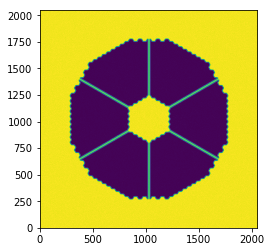

In [12]:
det_img, n1, n2 = make_detector_img(pup_img, npix_M1_N, phot_envirnt_N)
fits.writeto('det_img_N.fits', det_img, overwrite=True)

chi2=464.83, duration=68 s
chi2=484.55, duration=68 s
chi2=547.89, duration=68 s
chi2=649.3, duration=68 s
chi2=786.37, duration=67 s
chi2=952.96, duration=67 s


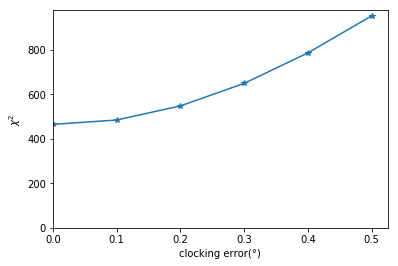

In [13]:
chi2s = calc_chi2(phot_envirnt_N, nrot=5, drot=0.1)
savefig('chi2_N.png', dpi=300, transparent=True)